# Hyperparameter Tuning with GridSearchCV

The [King County Housing Data](https://www.kaggle.com/harlfoxem/housesalesprediction/data) from Kaggle will be used.  The model will predict house price.

This notebook will demonstrate how to optimize hyperparameters using GridSearchCV and HyperOpt.

Scikit Learn also has RandomizedSearchCV, but it could be argued that if you do not have the processing time to perform a grid search, then you should take advantage of the Bayesian search offered by HyperOpt.

### Common Imports and Notebook Setup

In [362]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

### As per King County Housing Data EDA
TODO: provide link to that notebook

In [424]:
# read king county housing data
parser = lambda date: pd.datetime.strptime(date, '%Y%m%dT%H%M%S')
all_data = pd.read_csv('./data/kc_house_data.csv', parse_dates=['date'], date_parser=parser)

# Keep middle 80% by price
price = all_data['price']
low, high = price.quantile([0.1, 0.9])
price_filter = (price >= low) & (price <= high)
data = all_data[price_filter]

# compute mean sales price per house (id is house-id)
mean_price_by_id = data.groupby(['id'])['price'].mean()

# convert this to a data frame
mean_price_by_id = pd.DataFrame(mean_price_by_id).reset_index()

# join on id to get a new column for mean price
data = data.merge(right=mean_price_by_id, on='id', suffixes=['_orig', '_mean'])

# drop original price and de-dup the records
data = data.drop('price_orig', axis=1).drop_duplicates(subset='id')

# remove id and date fields
data = data.drop(['id', 'date'], axis=1)

# repace yr_built with yr_renovated if yr_renovated != 0
mask = data['yr_renovated'] != 0
data.loc[mask, 'yr_built'] = data.loc[mask, 'yr_renovated']
data = data.drop('yr_renovated',axis=1)

data = data.drop(['zipcode'], axis=1)

X = data.drop('price_mean', axis=1).values
y = data['price_mean'].values
print(X.shape)
print(y.shape)

(17281, 16)
(17281,)


### Parallezation
Searching through hyperparameter space is time consuming and embarrassingly parallel. There are several ways to parallelize the search.
* Set n_jobs=-1 and all the cores on your computer will be used
* XGBoost has it's own parallel API
* Dask-ML provides a simple interface for distributed parallel computing across multiple computers
* Dask also provides a more robust interface for distributed parallel computing
* Dask-XGBoost provides a wrapper around the XGBoost parallel API

When performing cross validation (of any type), the task could be parallelized at the model (for those models that have a n_jobs parameter) or for the cross validation operation itself.  It may not work correctly to set n_jobs=-1 for both the model (aka sklearn estimator) and cross validation, and even if it did, it would not run faster.  n_jobs=-1 should be set for either the model or cross validation, but not both.

The very simplest way to parallelize is to use all the cores on your computer.  Simply set n_jobs=-1.

The next simplest, which is worthwhile if you have 2 or more computers available, is to use Dask-ML.  That is the approach taken in this notebook as I have 2 computers available to perform distributed parallel processing.  To use Dask-ML on multiple computers, simply start a dask-scheduler process on one computer (e.g. your primary development machine) and start a dask-worker process on each computer which will perform the work. Making use of Dask-Ml simply requires importing the Dask parallel backend and using it with a with statement as shown below.

When using cross validation methods with Dask-ML, I would recommend parallelizing the cross validation method rather than parallelizing the model.

In [364]:
# Dask Setup
import dask_ml.joblib
from sklearn.externals.joblib import parallel_backend

### XGBoost
XGBoost will be used as the estimator.  It should be noted that LightGBM is similar and possibly better. It will not be used in this notebook as it is not as widely known.

XGBoost has several APIs.  Perhaps the two most important are the sklearn compatible API which will be used here, and the Learning API, which offers additional features such as early stopping.

When using the sklearn compatible API, do not pass parameters specific for the other APIs, such as early stopping rounds.  These will be accepted but may cause problems.

It should be noted that eta, aka the learning rate, should not be set too high as this can cause XGBoost to not find a solution.  If you get a mysterious error, try lowering the learning rate to, for example, 1.0. 

In [365]:
# create a default XGBRegressor
# explictly set n_jobs=1 to avoid problems with nested multiprocessing with cross validation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from xgboost import XGBRegressor
xgb_reg = XGBRegressor(n_jobs=1)
xgb_reg

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [366]:
# setup a cv generator for repeatability
k_folds = 10
random_seed=108
cv = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)

In [367]:
# compute the cross validated scores
# only 1 line of code is necessary to use Dask-ML for cross_val_score()
with parallel_backend('dask.distributed', scheduler_host='atlantis:8786'):
    scores = cross_val_score(xgb_reg, X, y, cv=cv, n_jobs=-1, 
                        scoring='neg_mean_absolute_error')
mad = -scores.mean()
mad

54253.48535307755

The default XGBRegressor is about the same as the as the model creating in TODO: provide notebook link.  After optimizing the hyperparameters, this model is likely to due much better.

### Objective Function is NOT Metric
XGBoost and some other estimators offer the ability to set both the objective function and the metric used for evaluation.  It is important to understand the difference between these.

The objective function is what will be optimized the the estimator.  This is independent of how you measure the score for your model.

In the above, the objective function was "reg:linear".  This means the objective is to minimize the sum of the squared errors.  This is equivalent to minimizing the mean of the squared errors.  Which is equivalent to minimizing the square root of the mean squared errors.  That is, "reg:linear" is consistent with the "rmse" XGBoost metric or the "neg_mean_squared_error" metric in Scikit Learn.

In the above, the metric chosen was "mae".  This was chosen because the model is predicting house prices and large errors in house prices more significantly affect the rmse score than the mae score and it can be argued mae is more what a end-user would understand for a house price prediction.

As "mae" is not what is being minimized, the natural question to ask is, "is there an objective function which can be minimized that will minimize the mae?".  mae does not have an analytical representation of the first and second derivatives, as is required by XGBoost (and LightGBM), however there are functions which are similar.  See for example: [How to use MAE as an Objective Function](https://stackoverflow.com/questions/45006341/xgboost-how-to-use-mae-as-objective-function)

Using a custom objective function is beyond the scope of this notebook, but will be explored in another notebook.  Here "reg:linear" will be used as the objective function and "mae" as the model scoring metric.

### Cross Validation Measures Model Performance
It is important to understand that cross validation does not create a model, it measure the score for the model in a manner that is reflective of how that model will work on out of sample data.

After measuring how well your model does, you will build the model on all available data.  This is important as cross validation creates a series of models, one per fold, each of which uses less than the full amount of available data.  Because each uses less than the full amount of data, each model that is created may be poorer than a model created using all the available data.

It is not necessary to use all the data if the model has reached its full capacity for learning.  This can be seen by looking at the Learning Curve for the model.  Another notebook is dedicated to Learning Curvers TODO place link here.

TODO: place this note in the right location:  GridSearchCV and RandomizedSearchCV do return a model, as a convenience, not as something inherent to GridSearch or Cross Validation.  The model it returns is trained on all the data provided to it.

### Feature Scaling
Tree based models do not need feature scaling.  However any algorithm that makes use of regularization, as XGBoost does by default, probably should use feature scaling.  This is to ensure that regularization does not use up its "quota of coefficients" using a large value for a variable with a small range.

It probably doesn't make much difference which scaler you use.  Below QuantileTransformer was used.

In [368]:
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
scale = QuantileTransformer(output_distribution='normal', random_state=10)

pipe = Pipeline(steps=[('scale', scale), ('xgb_reg', xgb_reg)])

In [369]:
# use same cv as before
k_folds = 10
random_seed=108
cv = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)

In [370]:
# compute the cross validated scores for the pipeline
# which consists of a scaler and the default XGBoostRegressor
with parallel_backend('dask.distributed', scheduler_host='atlantis:8786'):
    scores = cross_val_score(pipe, X, y, cv=cv, n_jobs=-1, 
                        scoring='neg_mean_absolute_error')
mad = -scores.mean()
mad

54202.75493478789

This score is very close to the previous score, so scaling the input features did not change anything with the default XGBRegressor model.  However if either of the regularization parameters, alpha or lambda, are to be optimized later, then having scaled the input features will make a difference.

### Hyperparameter Space
There are many hyperparmeters that could be tuned for XGBoost.  This is not a tutorial on XGBoost, but the most common parameters to optimize will be tried here.

For more information on parameter tunning see for example:
* [XGBoost Parameter Tuning](https://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html)  
* [Tuning Gradient Boosting](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)
* [Tuning XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

A general strategy is to first optimize eta, n_estimators (aka num_rounds) and max_depth.  After that, initial searching of the hyperparmeter space may be done.  The reason for this two (or more) step optimization strategy is that it reduces the size of the hyperparameter space search in a reasonable manner.  Another option is to use HyperOpt which will be discussed later.

In [371]:
# A rough rule of thumb is that as n_estimators goes up, eta goes down proportionally
eta = np.logspace(np.log10(0.01), np.log10(0.2), 5)
max_depth = list(range(1, 13))
n_estimators = np.round(np.logspace(np.log10(10), np.log10(1000), 3)).astype('int')
print(eta)
print(max_depth)
print(n_estimators)

[0.01       0.02114743 0.04472136 0.09457416 0.2       ]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[  10  100 1000]


### GridSearchCV
GridSearchCV takes a dictionary of parameter values to try.  All possible combination of all parameters values will be tried.  The number of combinations increases exponentially as the number of parameters increase, so care must be taken not to set up a GridSearch that is too large for your available computing resources.

GridSearcCV can also take a list of dictionaries.  The purpose of this is to avoid certain combinations of values that you know do not need to be tried, thereby reducing the search space and computing resources required.

GridSearchCV, like all cross validation methods, measures the score of the model as per the supplied metric.  GridSearchCV, has as a convenience to the user, the ability to return a model that is *retrained on all the data* using the best parameter values found.  It is retrained on all the data as this creates a better model than using a subset of the data (TODO: see Learning Curve notebook).

Note that XGBoost is optimizing the objective function, but GridSearchCV is reporting the scores based on the metric selected. If GridSearchCV is used to return the "best" model, which is trained on all the data, it will define "best" according to the metric that was selected, rather than the objective function that was minimized.

Note that GridSearchCV is optimizing the hyperparameters by computing the test scores over and over for each combination of hyperparameter values.  This is "data leakage".  The test set is being used implicitly by GridSearchCV to find the best hyperparameter values.  This may lead to an overly optimistic estimate of the model's performance.  See the following notebook for a deeper discussion of this issue: TODO link to notebook

#### Paramater Grid Dictionary
When using a pipeline, the syntax is to prepend the name of the object in the pipeline to the parameter being search over.

In [372]:
param_grid = {
        'xgb_reg__learning_rate': eta,
        'xgb_reg__max_depth': max_depth,
        'xgb_reg__n_estimators': n_estimators
}

In [373]:
# setup an cv generator for repeatability
k_folds = 5
random_seed=108
cv = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)

# use n_jobs=-1 to parallelize GridSearchCV
grid = GridSearchCV(pipe, cv=cv, n_jobs=-1, param_grid=param_grid, 
                    scoring='neg_mean_absolute_error', verbose=1)

In [377]:
from time import time

# if not using Dask, remove the line with 'with parallel_backend ...'
start = time()
with parallel_backend('dask.distributed', scheduler_host='atlantis:8786'):
    grid.fit(X, y)
    
    # for nested cross validation
    # scores = cross_val_score(grid, X, y, cv=3)
    
print(f'GridSearchCV Time: {time() - start: 5.1f} seconds')

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  8.8min finished


GridSearchCV Time:  545.5 seconds


Let's look at the best results

In [378]:
# save this result for later
cv_results = grid.cv_results_.copy()

In [379]:
print(f'Best Score: {grid.best_score_}')
print(grid.best_params_)

Best Score: -45346.02934490915
{'xgb_reg__learning_rate': 0.021147425268811283, 'xgb_reg__max_depth': 8, 'xgb_reg__n_estimators': 1000}


In [380]:
# pull the same information from the cv_results_ dictionary
argmax = np.argmax(grid.cv_results_['mean_test_score'])
best_score = grid.cv_results_['mean_test_score'][argmax]
print(f'Best Score: {best_score}')
print(grid.cv_results_['params'][argmax])

Best Score: -45346.02934490915
{'xgb_reg__learning_rate': 0.021147425268811283, 'xgb_reg__max_depth': 8, 'xgb_reg__n_estimators': 1000}


This is considerably better than the default xgb model.

### GridSearchCV Results
It is interesting to see the results expressed in hyperparameter space.

The results for the cross validated grid search are stored in grid.cv_results_

### Helper Functions to get Data from grid.cv_results
TODO: possibly move the helper functions to a different notebok

When cross_val_score() is used, an array of scores, one per fold, is returned.  This is convenient.

When GridSearchCV() is used, a different format is used.  This is not as convenient.  Below are some helper functions to reformat the output of GridSearchCV into an array per fold.

The dimensions of the array will be:
* len(learning_rate)
* len(max_depth)
* len(n_estimators)

In [390]:
# get the CV fold test score keys
def get_test_score_keys(grid):
    keys = []
    for key in grid.cv_results_.keys():
        if 'split' in key and 'test' in key:
            keys.append(key)
    return keys

In [391]:
# keys for K fold test scores
get_test_score_keys(grid)

['split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score']

In [392]:
# review the paramter grid passed in
grid.param_grid

{'xgb_reg__learning_rate': array([0.01      , 0.02114743, 0.04472136, 0.09457416, 0.2       ]),
 'xgb_reg__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 'xgb_reg__n_estimators': array([  10,  100, 1000])}

In [393]:
# GridSearchCV uses alphabetical order of parameter name
grid.cv_results_['params'][:1]

[{'xgb_reg__learning_rate': 0.01,
  'xgb_reg__max_depth': 1,
  'xgb_reg__n_estimators': 10}]

In [394]:
# Get the dimensions of the parameter grid
def get_dim(grid):
    dims = []
    for key in sorted(grid.param_grid.keys()):
        dims.append(len(grid.param_grid[key]))
    return tuple(dims)

In [395]:
# dimensions of parameter grid
get_dim(grid)

(5, 12, 3)

These dimensions match what is seen above for grid.cv_results_\['params'\]

In [396]:
# convert the CV test scores to an array
# Note: this requires that KFold was used for cv and not cv=<int>
def get_test_data(grid):
    dim = get_dim(grid)
    new_dim = (grid.cv.get_n_splits(), *dim)

    result = np.zeros(new_dim)
    for i, key in enumerate(get_test_score_keys(grid)):
        data = np.array(grid.cv_results_[key])
        data = data.reshape(dim)
        result[i] = data

    return result

In [397]:
# There are 5 (5, 12, 3) CV test scores because there are 5 folds
get_test_data(grid).shape

(5, 5, 12, 3)

In [398]:
# verify the helper functions work properly

# compute mean test score using the above numpy array
test_data = get_test_data(grid)
mean_scores = test_data.mean(axis=0)
print(mean_scores.shape)

# retrieve mean test score directly from cv_results_
mean_scores2 = grid.cv_results_['mean_test_score']
mean_scores2 = mean_scores2.reshape(get_dim(grid))

# verify that every value is (almost) the same
print(np.allclose(mean_scores, mean_scores2, rtol=5e-6))

(5, 12, 3)
True


So the helper methods work correctly.

### Examine Hyperparameter Space
One way to view the hyperparameter space is as contour plots.  This allows for observing the score vs two hyperparameters.  A series of hyperparameter plots provides information on 3 parameters.

In [399]:
# define the contour scaling
levels=list(range(-110000, -60000, 1000))

Text(0.5,1,'N Rounds = 10')

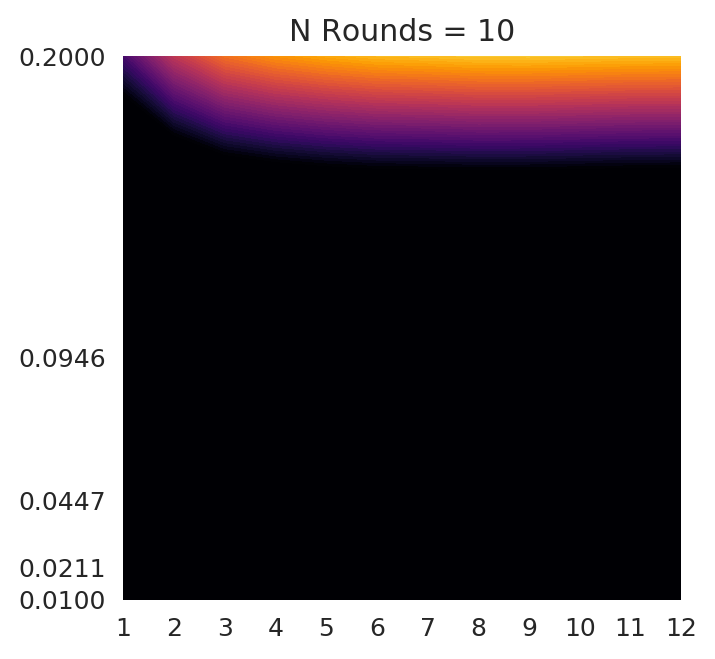

In [400]:
# plt.gca().invert_yaxis()
# lighter colors are higher
# score is negative error, so ligher is better
plt.figure(dpi=180, figsize=(4,4))
plt.xticks(max_depth)
plt.yticks(eta)
CS = plt.contourf(max_depth, eta, mean_scores[:, :, 0], cmap='inferno', levels=levels, extend='min')
# plt.clabel(CS, inline=1, fontsize=10, colors='black')
plt.title(f'N Rounds = {n_estimators[0]}')

From the above it appears that for n_estimators=10, eta should be larger than 0.20.  As n_estimators=10 does not produce good results, it will not be examine further.

In [401]:
# use this scaling for the next 2 contour plots
levels=list(range(-50000, -45000, 100))

Text(0.5,1,'N Rounds = 100')

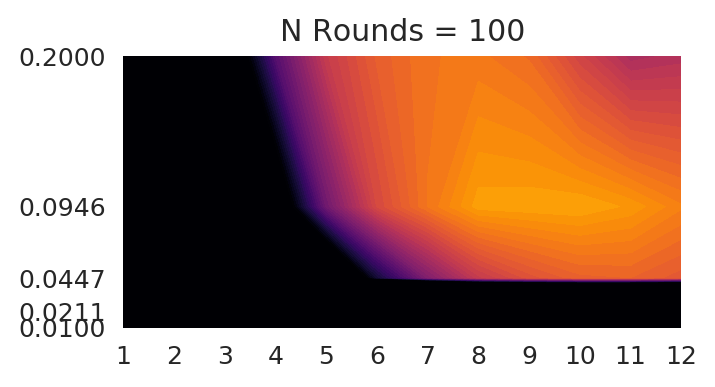

In [402]:
# plt.gca().invert_yaxis()
# lighter colors are higher
# score is negative error, so ligher is better
plt.figure(dpi=180, figsize=(4,2))
plt.xticks(max_depth)
plt.yticks(eta)
CS = plt.contourf(max_depth, eta, mean_scores[:, :, 1], cmap='inferno', levels=levels, extend='min')
# plt.clabel(CS, inline=1, fontsize=10, colors='black')
plt.title(f'N Rounds = {n_estimators[1]}')

As per the above, for 100 boosting rounds (100 estimators), eta is optimal around .0946 with max_depth between 8 and 11.

Text(0.5,1,'N Rounds = 1000')

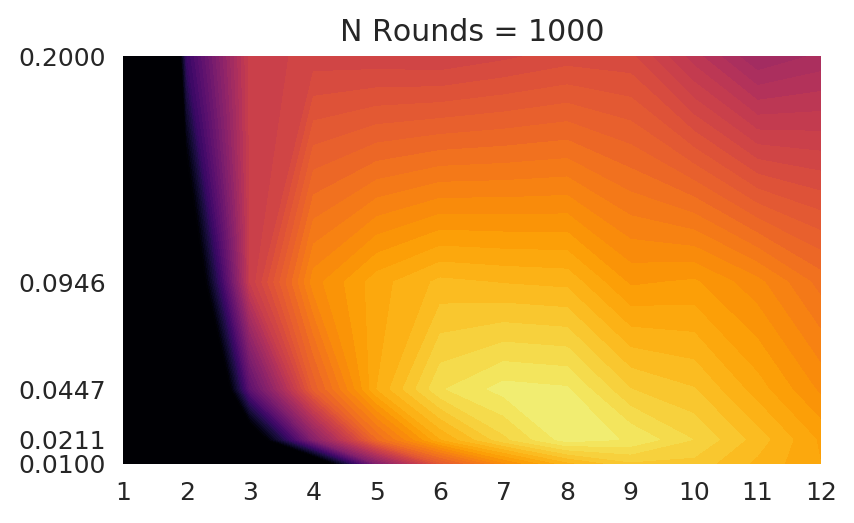

In [403]:
# plt.gca().invert_yaxis()
# lighter colors are higher
# score is negative error, so ligher is better
plt.figure(dpi=180, figsize=(5,3))
plt.xticks(max_depth)
plt.yticks(eta)
CS = plt.contourf(max_depth, eta, mean_scores[:, :, 2], cmap='inferno', levels=levels, extend='min')
# plt.clabel(CS, inline=1, fontsize=10, colors='black')
plt.title(f'N Rounds = {n_estimators[2]}')

At n_estimators = 1000, the results are much better than at 100 or 10.  The optimal eta values are between about .02 and .05 and the optimal max_depth is between about 7 and 9.  From best_score_ and best_params_, we know the  best (highest negative error) was -45346 at .0211, with max_depth = 8.

The contour plot creates more contours than available from the data, so it is interpolating.  Had the grid been more dense, the contour plot might look slightly different.

The most important thing to note about the contour plot is that the best score is an an area where the contours are smooth.  Had the best value in a non-smooth part of the surface, this would suggest the hyperparameters were overfit.

Let's zoom in on the area of interest by creating a new parameter grid and running GridSearchCV again.

In [404]:
eta = np.logspace(np.log10(.02),np.log10(.06), 6)
max_depth = [6, 7, 8, 9]
n_estimators = [1000]
print(eta)
print(max_depth)
print(n_estimators)

[0.02       0.02491462 0.03103691 0.03866364 0.04816449 0.06      ]
[6, 7, 8, 9]
[1000]


In [405]:
param_grid = {
        'xgb_reg__learning_rate': eta,
        'xgb_reg__max_depth': max_depth,
        'xgb_reg__n_estimators': n_estimators
}

In [407]:
from time import time

# setup an explict cv generator for repeatability
k_folds = 5
random_seed=108
cv = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)

grid2 = GridSearchCV(pipe, cv=cv, n_jobs=-1, param_grid=param_grid, 
                    scoring='neg_mean_absolute_error', verbose=1)

In [408]:
# the only dask command is: with parallel_backend ...
start = time()
with parallel_backend('dask.distributed', scheduler_host='atlantis:8786'):
    grid2.fit(X, y)
    
    # for nested cross validation
    # scores = cross_val_score(grid, X_all, y_all, cv=3)
    
print(f'GridSearchCV Time: {time() - start: 5.1f} seconds')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.5min finished


GridSearchCV Time:  228.9 seconds


In [409]:
print(grid2.best_score_)
grid2.best_params_

-45284.56908870291


{'xgb_reg__learning_rate': 0.02491461879231035,
 'xgb_reg__max_depth': 8,
 'xgb_reg__n_estimators': 1000}

Although this score is slightly better, it is likely not meaningfully better, given that the variance in cross validation estimated model scores is high.  It is important to note that there is no unbiased estimator of cross validation variance.  This means there is no unbiased way to create a confidence interval around the estimate of the model's score.  The standard deviation is useful in a relative sense in that for non-repeated CV, if the same CV setup is used, the standard deviation will provide a measure of the variance.  TODO: see notebook on CV variance

In [412]:
test_data = get_test_data(grid2)
mean_scores = test_data.mean(axis=0)

In [413]:
# define contour scaling (finer resolution than above)
levels=list(range(-46000, -45000, 50))

Text(0.5,1,'N Rounds = 1000')

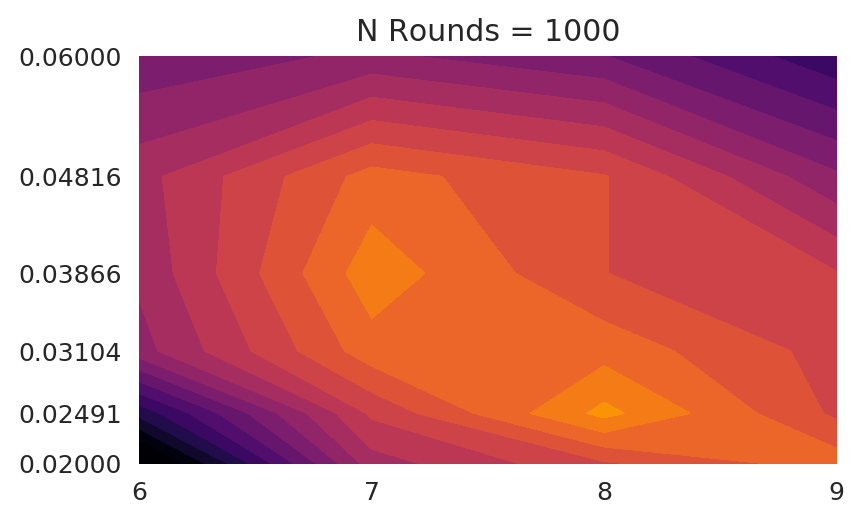

In [414]:
# plt.gca().invert_yaxis()
# lighter colors are higher
# score is negative error, so ligher is better
plt.figure(dpi=180, figsize=(5,3))
plt.xticks(max_depth)
plt.yticks(eta)
CS = plt.contourf(max_depth, eta, mean_scores[:, :, 0], cmap='inferno', levels=levels, extend='min')
# plt.clabel(CS, inline=1, fontsize=10, colors='black')
plt.title(f'N Rounds = {n_estimators[0]}')

max_depth of 7-9 with eta of .02 to .05 all looks good.

If I had to pick one value based on the plot, I would pick max_depth = 7 and eta = 0.03866.  This is because the surface is smoother than in the neighborhood of the very highest peak and is therefore more likely to generalize well.  Although to ensure good generalization, increasing the regularization is likely the best bet.

Contour plots are often easier to view than a 3D plot, but let's try a 3D plot.

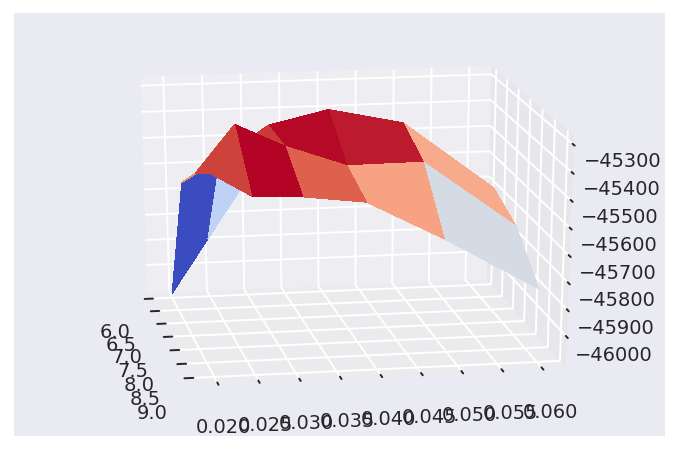

In [423]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(dpi=140)
ax = fig.gca(projection='3d')
ax.view_init(20, -10)

# Make data.
X_mesh, Y_mesh = np.meshgrid(max_depth, eta)

# Plot the surface.
surf = ax.plot_surface(X_mesh, Y_mesh, mean_scores[:, :, 0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

### Early Stopping
TODO: may move this section to another notebook

In order to use early stopping, the XGBoost Learning API must be used.

1000 rounds may be more than necessary and/or it may cause overfitting.

In [425]:
X.shape, y.shape

((17281, 16), (17281,))

In [310]:
# Note the following uses unscaled features
import xgboost as xgb
data_dmatrix = xgb.DMatrix(X, label=y)

In [320]:
params = {
        'learning_rate': 0.0249146,
        'max_depth': 8,
}

In [429]:
results = xgb.cv(params, data_dmatrix, num_boost_round=1000, early_stopping_rounds=2, metrics='mae')
results.tail()

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
500,31307.828776,308.434342,46656.088542,727.298335
501,31292.354818,308.125657,46655.513021,727.552547
502,31269.155599,301.075706,46652.269531,727.851610
503,31251.837891,294.179151,46652.829427,727.398226
504,31229.014323,282.423967,46645.320312,732.058867


In [430]:
results = xgb.cv(params, data_dmatrix, num_boost_round=1000, early_stopping_rounds=100, metrics='mae')
results.tail()

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
995,24389.766276,66.054554,46012.122396,701.859736
996,24378.778646,68.975705,46010.927083,701.749848
997,24365.950521,72.187622,46011.550781,701.481049
998,24352.312500,78.940070,46012.003906,698.679801
999,24337.138672,79.934957,46008.825521,700.169213


What would the "1 sigma rule" of ISL look like here?

The best result was 46009 with a standard deviation of 700.  Reducing complexity means to reduce the number of boosting rounds, so the best model with less boosting rounds within 1 standard deviation would be a model with 46008 + 700 = 46708.  This corresponds to using about 375 trees as shown below.

In [438]:
results.iloc[376]

train-mae-mean    33524.501302
train-mae-std       302.336718
test-mae-mean     47010.033854
test-mae-std        792.899480
Name: 376, dtype: float64

In [441]:
# lambda is L2 regularization and defaults to 1.0
# alpha is L1 regularization and defaults to 0.0
params = {
    'learning_rate': 0.0249146,
    'max_depth': 8,
    'lambda': 2.0,
    'alpha': 2.0
}

In [442]:
# what happens if we increase the regularization?
resultsL2 = xgb.cv(params, data_dmatrix, num_boost_round=1000, early_stopping_rounds=100, metrics='mae')
resultsL2.tail()

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
995,19129.746094,59.941202,46029.782552,473.808287
996,19118.326823,58.588092,46031.341146,473.236605
997,19108.113932,55.288738,46031.648437,472.003738
998,19091.824870,54.757202,46032.718750,471.713605
999,19080.793620,52.775901,46032.483073,471.766782


The test score is about the same but the standard deviation is lower.  This makes sense as a more conservative model will make more consistent predictions.

In [443]:
# increase the regularization more
params = {
    'learning_rate': 0.0249146,
    'max_depth': 8,
    'lambda': 5.0,
    'alpha': 5.0
}
resultsL5 = xgb.cv(params, data_dmatrix, num_boost_round=1000, early_stopping_rounds=100, metrics='mae')
resultsL5.tail()

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
995,21526.843099,136.307834,45823.937500,524.723557
996,21516.546875,131.356879,45824.894531,524.374157
997,21505.300781,130.969149,45825.335938,525.106844
998,21493.729818,135.617038,45824.226562,524.269211
999,21485.140625,135.083457,45824.953125,523.924645


The test score is lower (and the training score is higher).  This is likely to be a better generalizing model.

TODO: Create a Notebook for Validation Curves using XGBoost train and test data from xgb.cv  Can use standard deviation as the error bar.

In [444]:
# more randomization
# default colsample_bytree is 1.0
params = {
    'learning_rate': 0.0249146,
    'max_depth': 8,
    'colsample_bytree': 0.5,
}
resultsSample05 = xgb.cv(params, data_dmatrix, num_boost_round=1000, early_stopping_rounds=100, metrics='mae')
resultsSample05.tail()

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
995,17685.556641,203.452827,45771.826823,620.978494
996,17677.858073,203.135099,45772.020833,621.390638
997,17665.754558,202.628272,45770.569010,622.150400
998,17654.020182,201.327501,45770.154948,623.511390
999,17646.047526,205.705755,45770.053386,623.205033


TODO: Consider Huber Loss Function.  Should home in better on a minimum mae.

In [445]:
np.show_config()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/home/agni/anaconda3/envs/anaconda/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/home/agni/anaconda3/envs/anaconda/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
  NOT AVAILABLE
openblas_clapack_info:
  NOT AVAILABLE
atlas_3_10_threads_info:
    include_dirs = ['/home/agni/anaconda3/envs/anaconda/include']
    language = c
    libraries = ['openblas', 'openblas']
    library_dirs = ['/home/agni/anaconda3/envs/anaconda/lib']
    define_macros = [('ATLAS_WITHOUT_LAPACK', None)]
lapack_info:
    libraries = ['lapack', 'lapack']
    library_dirs = ['/home/agni/anaconda3/envs/anaconda/lib']
    language = f77
lapack_opt_info:
    include_dirs = ['/home/agni/anaconda3/envs/anaconda/include'